In [3]:
pip install ucimlrepo

Importing Essential Libraries

In [4]:
'''
List of available features:

 1. age: continuous (years)
 2. sex: categorical, 2 values {0: female, 1: male}
 3. cp (chest pain type): categorical, 4 values
    {1: typical angina, 2: atypical angina, 3: non-angina, 4: asymptomatic angina}
 4. trestbps (resting blood pressure): continuous (mmHg)
 5. chol (serum cholesterol level): continuous (mg/dl)
 6. fbs (fasting blood sugar): categorical, 2 values {0: <= 120 mg/dl, 1: > 120 mg/dl}
 7. restecg (resting electrocardiography): categorical, 3 values
    {0: normal, 1: ST-T wave abnormality, 2: left ventricular hypertrophy}
 8. thalach (maximum heart rate achieved): continuous
 9. exang (exercise induced angina): categorical, 2 values {0: no, 1: yes}
10. oldpeak (ST depression induced by exercise relative to rest): continuous
11. slope (slope of peak exercise ST segment): categorical, 3 values
    {1: upsloping, 2: flat, 3: downsloping}
12. ca (number of major vessels colored by fluoroscopy): discrete (0,1,2,3)
13. thal: categorical, 3 values {3: normal, 6: fixed defect, 7: reversible defect}
14. num (diagnosis of heart disease): categorical, 5 values
    {0: < 50% diameter narrowing, 1: > 50% diameter narrowing in 1 vessel,
    2: > 50% diameter narrowing in 2 vessels, 3: > 50% diameter narrowing in 3 vessels,
    4: > 50% diameter narrowing in 4 vessels}
'''

from ucimlrepo import fetch_ucirepo
# Regular EDA (exploratory data analysis) and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
# Training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Model Evaluations
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score


# Tuning
from sklearn.model_selection import GridSearchCV

# Ignoring the warnings
import warnings
warnings.filterwarnings("ignore")


Loading Dataset

In [5]:
# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# metadata
print(heart_disease.metadata)

# variable information
print(heart_disease.variables)



{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

In [6]:
# Concatenate features (X) and target variable (y) into a single DataFrame
df = pd.concat([X, y], axis=1)

In [7]:
# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumns and Data Types:")
print(df.dtypes)

Dataset Shape: (303, 14)

Columns and Data Types:
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
num           int64
dtype: object


In [8]:
# Display the first few rows of the dataframe
print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  num  
0  0.0   6.0    0  
1  3.0   3.0    2  
2  2.0   7.0    1  
3  0.0   3.0    0  
4  0.0   3.0    0  


In [9]:
# Display the last few rows of the DataFrame
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3.0,0


In [10]:
# Summarize numeric columns with descriptive statistics
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


# **Data Cleaning & Preprocessing**

In [11]:
# Show the non null count and datatypes of the variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


In [12]:
# Checking duplicate values
data_dup = df.duplicated().any()
if data_dup:
    # If duplicates are found, drop them
    df_encoded = df.drop_duplicates()
    print("Duplicates removed.")
else:
    print("No duplicates found.")

No duplicates found.


In [13]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64


In [14]:
# Impute missing values in 'ca' column with the median
df['ca'].fillna(df['ca'].median(), inplace=True)

# Impute missing values in 'thal' column with the mode
df['thal'].fillna(df['thal'].mode()[0], inplace=True)


In [15]:
# Check for missing values after handling
print(df.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


In [16]:
# Map heart disease diagnosis to binary: 0 for absence, 1 for presence
df['num'] = df.num.map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})

# Map gender to categorical labels: 0 to 'female', 1 to 'male'
df['sex'] = df.sex.map({0: 'female', 1: 'male'})


In [17]:
# Check the unique values in the 'num' column
print(df['num'].unique())

[0 1]


Feature Encoding

In [18]:
# Perform one-hot encoding for categorical features
categorical_cols = ['cp', 'fbs', 'restecg', 'exang', 'slope']
df_encoded = pd.get_dummies(df, columns=categorical_cols + ['sex'])

# Display the first few rows of the encoded dataframe
print(df_encoded.head())

   age  trestbps  chol  thalach  oldpeak   ca  thal  num  cp_1  cp_2  ...  \
0   63       145   233      150      2.3  0.0   6.0    0     1     0  ...   
1   67       160   286      108      1.5  3.0   3.0    1     0     0  ...   
2   67       120   229      129      2.6  2.0   7.0    1     0     0  ...   
3   37       130   250      187      3.5  0.0   3.0    0     0     0  ...   
4   41       130   204      172      1.4  0.0   3.0    0     0     1  ...   

   restecg_0  restecg_1  restecg_2  exang_0  exang_1  slope_1  slope_2  \
0          0          0          1        1        0        0        0   
1          0          0          1        0        1        0        1   
2          0          0          1        0        1        0        1   
3          1          0          0        1        0        0        0   
4          0          0          1        1        0        1        0   

   slope_3  sex_female  sex_male  
0        1           0         1  
1        0           0

Checking Outliers

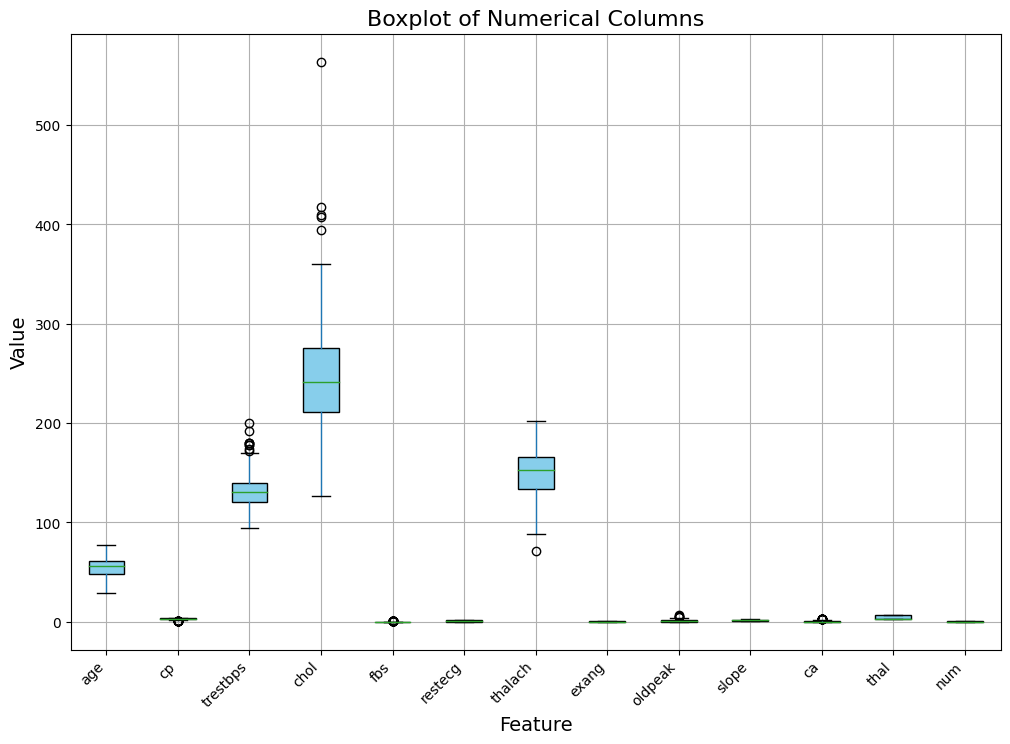

In [19]:
# Select numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64'])

# Create a boxplot with filled colors
plt.figure(figsize=(12, 8))
bp = numerical_columns.boxplot(patch_artist=True, boxprops=dict(facecolor="skyblue"))

# Customize labels and title
plt.title("Boxplot of Numerical Columns", fontsize=16)
plt.xlabel("Feature", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [20]:
# Calculate Z-scores for each column
z_scores = numerical_columns.apply(zscore)

# Calculate IQR
Q1 = numerical_columns.quantile(0.25)
Q3 = numerical_columns.quantile(0.75)
IQR = Q3 - Q1

# Define thresholds for IQR-based outlier detection (adjust thresholds if needed)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flag outliers using Z-score and IQR
outliers_zscore = (z_scores > 3) | (z_scores < -3)
outliers_iqr = (numerical_columns < lower_bound) | (numerical_columns > upper_bound)
outliers_combined = outliers_zscore | outliers_iqr


In [21]:
# Find rows where outliers are identified
outlier_indices = outliers_combined.any(axis=1)

# Print indices or rows where outliers are identified
print("Indices or rows where outliers are identified:")
print(numerical_columns[outlier_indices])


Indices or rows where outliers are identified:
     age  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0     63   1       145   233    1        2      150      0      2.3      3   
1     67   4       160   286    0        2      108      1      1.5      2   
9     53   4       140   203    1        2      155      1      3.1      3   
12    56   3       130   256    1        2      142      1      0.6      2   
14    52   3       172   199    1        0      162      0      0.5      1   
..   ...  ..       ...   ...  ...      ...      ...    ...      ...    ...   
285   58   4       114   318    0        1      140      0      4.4      3   
286   58   4       170   225    1        2      146      1      2.8      2   
296   59   4       164   176    1        2       90      0      1.0      2   
298   45   1       110   264    0        0      132      0      1.2      2   
299   68   4       144   193    1        0      141      0      3.4      2   

      ca  thal  

In [22]:
# Remove outlier rows
numerical_columns_cleaned = numerical_columns[~outlier_indices]

# Print the cleaned numerical columns
print("Cleaned Numerical Columns:")
print(numerical_columns_cleaned)


Cleaned Numerical Columns:
     age  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
2     67   4       120   229    0        2      129      1      2.6      2   
3     37   3       130   250    0        0      187      0      3.5      3   
4     41   2       130   204    0        2      172      0      1.4      1   
5     56   2       120   236    0        0      178      0      0.8      1   
6     62   4       140   268    0        2      160      0      3.6      3   
..   ...  ..       ...   ...  ...      ...      ...    ...      ...    ...   
295   41   2       120   157    0        0      182      0      0.0      1   
297   57   4       140   241    0        0      123      1      0.2      2   
300   57   4       130   131    0        0      115      1      1.2      2   
301   57   2       130   236    0        2      174      0      0.0      2   
302   38   3       138   175    0        0      173      0      0.0      1   

      ca  thal  num  
2    2.0   7.0

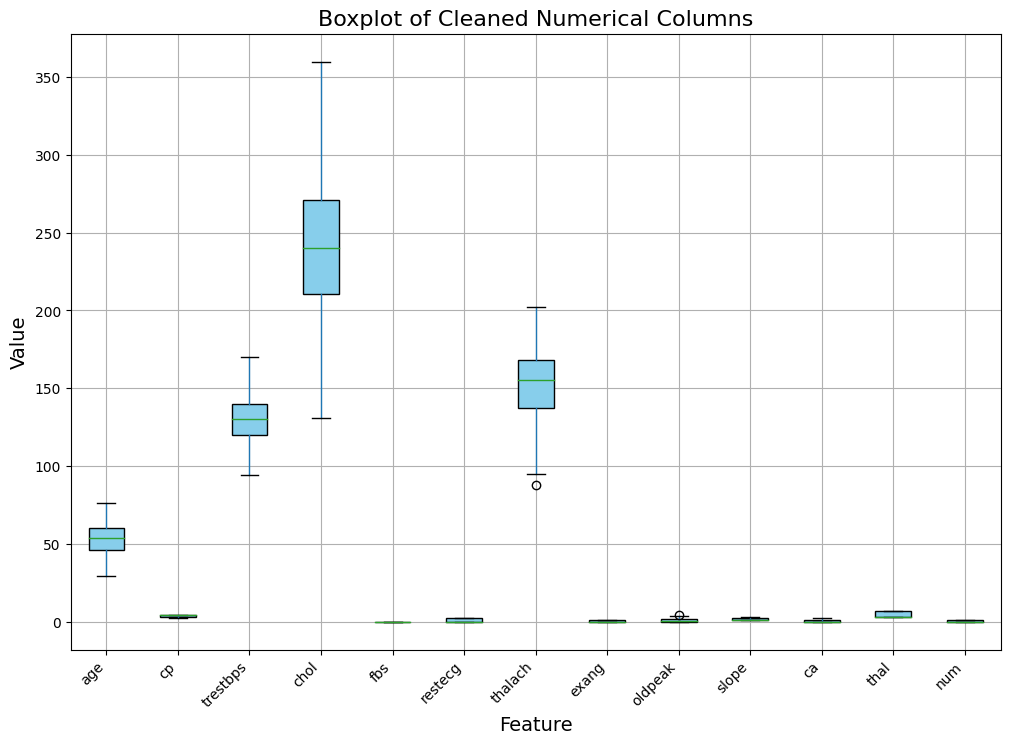

In [23]:
# Create a boxplot of the cleaned numerical columns
plt.figure(figsize=(12, 8))
numerical_columns_cleaned.boxplot(patch_artist=True, boxprops=dict(facecolor="skyblue"))
plt.title("Boxplot of Cleaned Numerical Columns", fontsize=16)
plt.xlabel("Feature", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

Handling Outliers in 'thalach' & 'oldpeak' column

Outliers in 'thalach' column have been successfully removed.


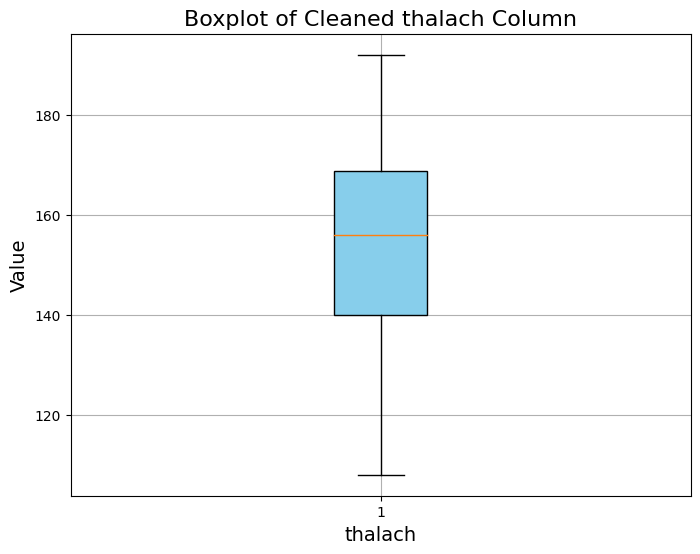

Outliers in 'oldpeak' column have been successfully removed.


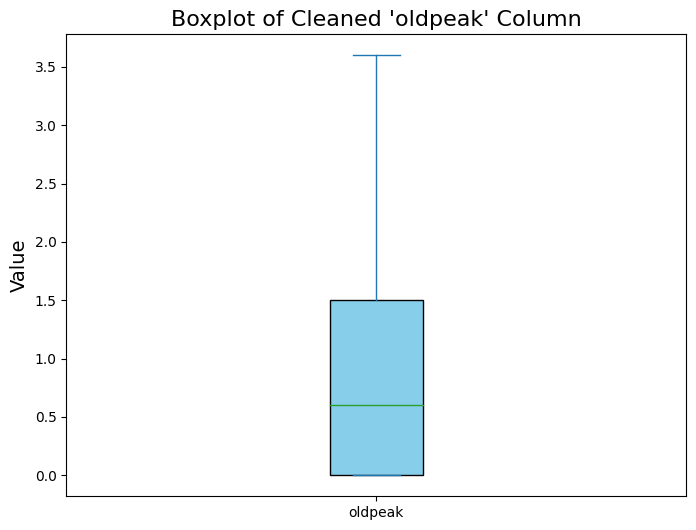

In [24]:
# Calculate Z-scores for 'thalach' column
z_scores_thalach = (numerical_columns_cleaned['thalach'] - numerical_columns_cleaned['thalach'].mean()) / numerical_columns_cleaned['thalach'].std()

# Adjust Z-score threshold for 'thalach'
z_score_threshold_thalach = 2

# Flag outliers for 'thalach'
outliers_thalach = (z_scores_thalach > z_score_threshold_thalach) | (z_scores_thalach < -z_score_threshold_thalach)

# Identify and remove outliers for 'thalach'
cleaned_data_adjusted = numerical_columns_cleaned[~outliers_thalach]

# Check if outliers are removed for 'thalach'
if len(cleaned_data_adjusted) == len(numerical_columns_cleaned) - sum(outliers_thalach):
    print("Outliers in 'thalach' column have been successfully removed.")
else:
    print("Outliers in 'thalach' column may still exist in the data.")

# Plot boxplot of cleaned 'thalach' column
plt.figure(figsize=(8, 6))
plt.boxplot(cleaned_data_adjusted['thalach'], patch_artist=True, boxprops=dict(facecolor="skyblue"))
plt.title('Boxplot of Cleaned thalach Column', fontsize=16)
plt.xlabel('thalach', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.grid(True)
plt.show()

# Calculate Z-scores for 'oldpeak' column
z_scores_oldpeak = (numerical_columns_cleaned['oldpeak'] - numerical_columns_cleaned['oldpeak'].mean()) / numerical_columns_cleaned['oldpeak'].std()

# Adjust Z-score threshold for 'oldpeak'
z_score_threshold_oldpeak = 3

# Flag outliers for 'oldpeak'
outliers_oldpeak = (z_scores_oldpeak > z_score_threshold_oldpeak) | (z_scores_oldpeak < -z_score_threshold_oldpeak)

# Identify and remove outliers for 'oldpeak'
cleaned_data_adjusted = numerical_columns_cleaned[~outliers_oldpeak]

# Check if outliers are removed for 'oldpeak'
if len(cleaned_data_adjusted) == len(numerical_columns_cleaned) - sum(outliers_oldpeak):
    print("Outliers in 'oldpeak' column have been successfully removed.")
else:
    print("Outliers in 'oldpeak' column may still exist in the data.")

# Create a boxplot of the cleaned 'oldpeak' column
plt.figure(figsize=(8, 6))
cleaned_data_adjusted['oldpeak'].plot(kind='box', patch_artist=True, boxprops=dict(facecolor="skyblue"))
plt.title("Boxplot of Cleaned 'oldpeak' Column", fontsize=16)
plt.ylabel("Value", fontsize=14)
plt.show()


# **Exploratory Data Analysis**

In [25]:
# Count the occurrences of each class in the target variable
heart_disease_counts = df['num'].value_counts()

# Print the counts:
infected = heart_disease_counts.iloc[1:].sum()
not_infected = heart_disease_counts[0]
print(f"{infected} were infected with heart disease.\n{not_infected} were not infected with heart disease.")

139 were infected with heart disease.
164 were not infected with heart disease.


Checking correlation between columns

In [26]:
print(df.corr()["num"].abs().sort_values(ascending=False)) #This shows that most columns are moderately correlated with target, but 'fbs' is very weakly correlated.


num         1.000000
thal        0.522057
ca          0.460033
exang       0.431894
oldpeak     0.424510
thalach     0.417167
cp          0.414446
slope       0.339213
age         0.223120
restecg     0.169202
trestbps    0.150825
chol        0.085164
fbs         0.025264
Name: num, dtype: float64


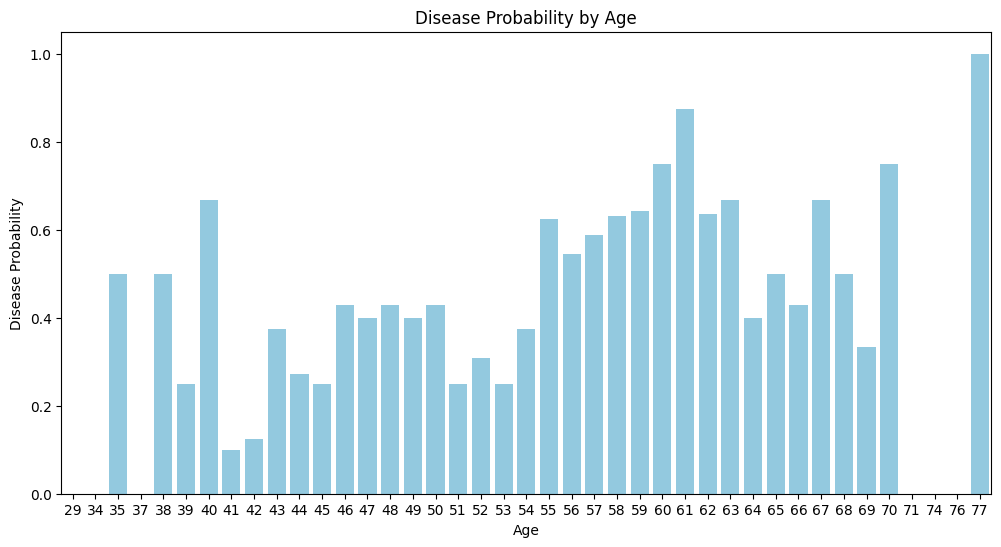

In [27]:
# Group data by 'age' and calculate the average of 'num'
avg = df.groupby('age')['num'].mean().reset_index()

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='age', y='num', data=avg, color='skyblue')

# Set labels for x-axis and y-axis
plt.xlabel('Age')
plt.ylabel('Disease Probability')

# Set plot title
plt.title('Disease Probability by Age')

# Show the plot
plt.show()

Analysing target (num) *variable*

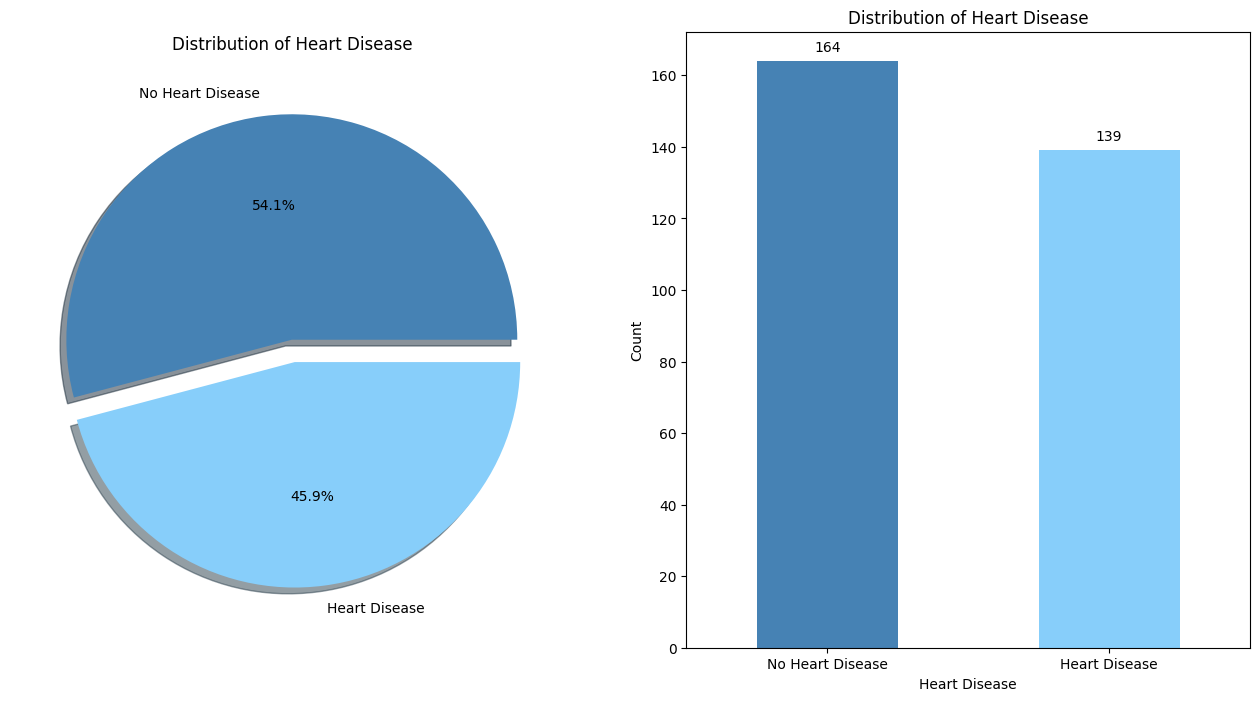

In [28]:
# Replace '1' with 'Heart Disease' and '0' with 'No Heart Disease'
df['num'] = df['num'].replace({1: 'Heart Disease', 0: 'No Heart Disease'})

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Pie chart
df['num'].value_counts().plot(
    kind='pie', colors=["#4682B4", "#87CEFA"], ax=ax[0], explode=[0, 0.1], autopct='%1.1f%%', shadow=True
)
ax[0].set_ylabel('')
ax[0].set_title('Distribution of Heart Disease')

# Bar chart
bar_plot = df['num'].value_counts().plot(
    kind='bar', color=["#4682B4", "#87CEFA"], ax=ax[1]
)
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Heart Disease')
ax[1].set_xticklabels(["No Heart Disease", "Heart Disease"], rotation=0)
ax[1].set_title('Distribution of Heart Disease')

# Add count labels on top of the bars
for p in bar_plot.patches:
    ax[1].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


Analysing the 'Sex' feature

In [29]:
df["sex"].unique()

array(['male', 'female'], dtype=object)

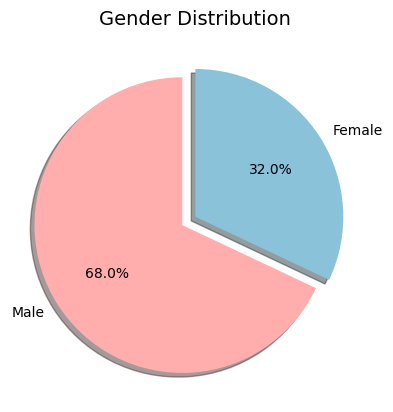

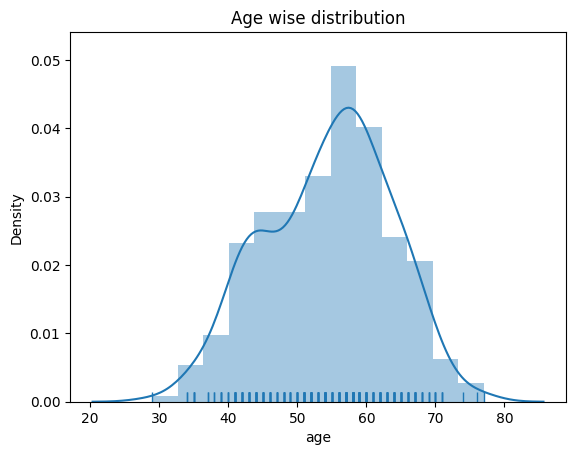

In [30]:
# Check gender distribution in the dataset
gender_dist = df['sex'].value_counts()

# Plotting the pie chart for gender distribution
plt.figure()
plt.pie(gender_dist, labels=['Male', 'Female'], autopct = '%1.1f%%', colors=['#ffadad','#89c2d9'],shadow=True, startangle=90,explode=[0.1, 0.005])
plt.title("Gender Distribution", fontsize=14, color='black')
plt.show()

ax= sns.distplot(df['age'], rug=True)
plt.title("Age wise distribution")
plt.show()


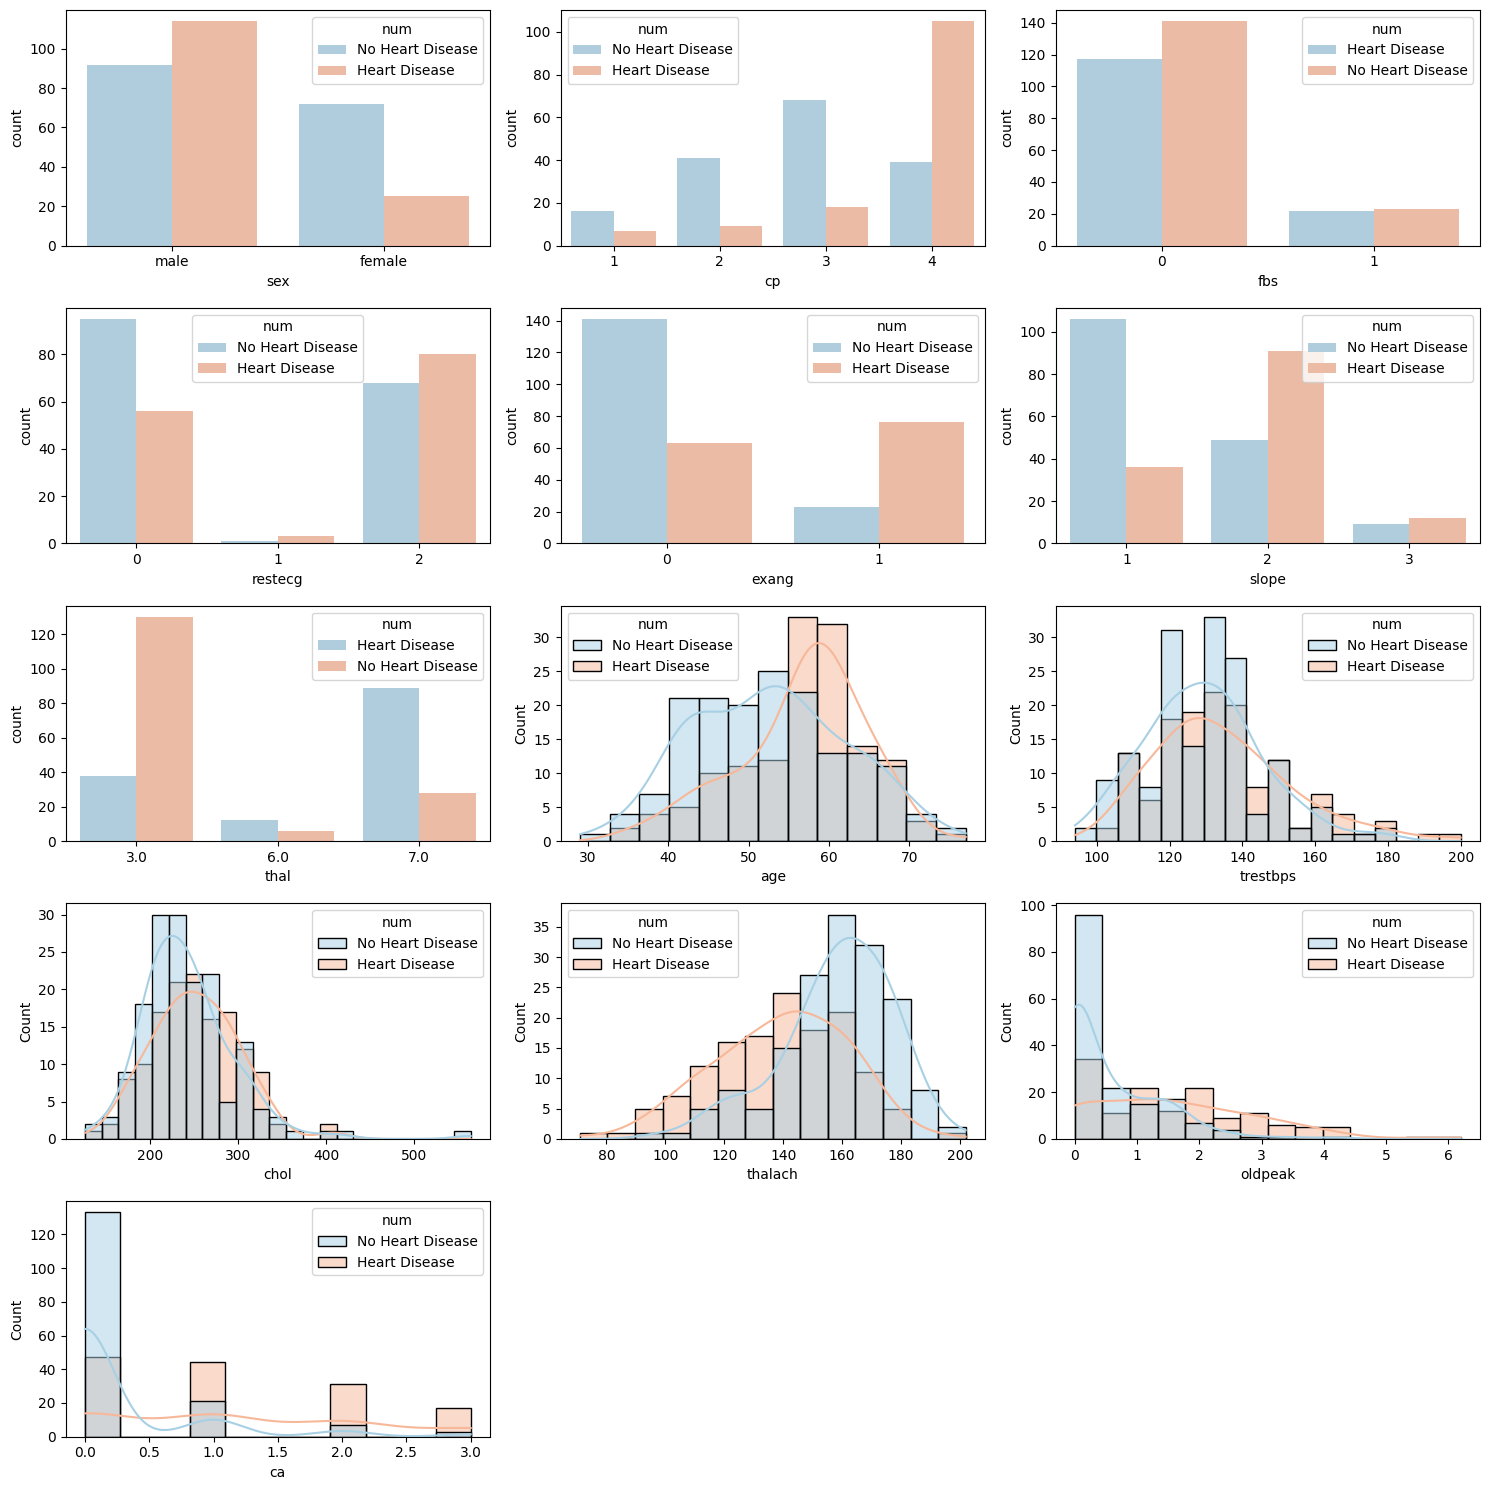

In [31]:
# Manually specify categorical variables (excluding 'num')
categorical_vars = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Identify continuous variables (excluding 'num')
continuous_vars = [col for col in df.columns if col not in categorical_vars and col != 'num']

# Calculate the number of rows and columns needed for subplots
num_subplots = len(categorical_vars) + len(continuous_vars)
num_cols = 3  # Set the number of columns to a fixed value
num_rows = (num_subplots // num_cols) + (num_subplots % num_cols > 0)  # Calculate the number of rows needed

# Set up subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axs = axs.flatten()

# Categorical variables count plots
for i, var in enumerate(categorical_vars):
    sns.countplot(x=var, data=df, hue='num', ax=axs[i], palette='RdBu_r')

# Continuous variables histograms
for i, var in enumerate(continuous_vars):
    sns.histplot(data=df, x=var, kde=True, hue='num', ax=axs[len(categorical_vars) + i], palette='RdBu_r')

# Hide unused subplots
for j in range(num_subplots, len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


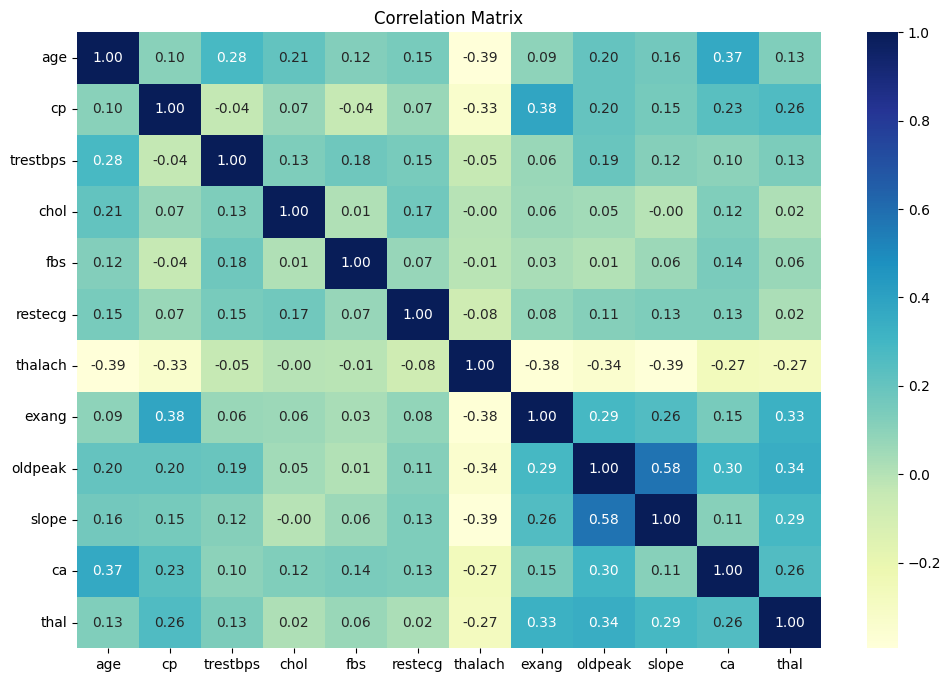

In [32]:
# Correlation Analysis
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Correlation Matrix")
plt.show()


In [33]:
# Correlation Analysis
correlation_matrix = df.corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
               age        cp  trestbps      chol       fbs   restecg  \
age       1.000000  0.104139  0.284946  0.208950  0.118530  0.148868   
cp        0.104139  1.000000 -0.036077  0.072319 -0.039975  0.067505   
trestbps  0.284946 -0.036077  1.000000  0.130120  0.175340  0.146560   
chol      0.208950  0.072319  0.130120  1.000000  0.009841  0.171043   
fbs       0.118530 -0.039975  0.175340  0.009841  1.000000  0.069564   
restecg   0.148868  0.067505  0.146560  0.171043  0.069564  1.000000   
thalach  -0.393806 -0.334422 -0.045351 -0.003432 -0.007854 -0.083389   
exang     0.091661  0.384060  0.064762  0.061310  0.025665  0.084867   
oldpeak   0.203805  0.202277  0.189171  0.046564  0.005747  0.114133   
slope     0.161770  0.152050  0.117382 -0.004062  0.059894  0.133946   
ca        0.365323  0.233117  0.097528  0.123726  0.140764  0.131749   
thal      0.128303  0.262089  0.134424  0.018351  0.064625  0.024325   

           thalach     exang   oldpeak     

# Splitting the Data

In [34]:
# Separate features (X) and target variable (y)
X = df_encoded.drop(columns=['num'])  # Features
y = df_encoded['num']  # Target variable

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print('There are {} samples in the training set and {} samples in the test set'.format(X_train.shape[0], X_test.shape[0]))



There are 212 samples in the training set and 46 samples in the test set


# Feature Scaling

In [35]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and validation data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Model Development

In [36]:
# Function to plot confusion matrix and find false negative rate of model
def plot_confusion_matrix(y_true, y_pred, title):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate false negative rate
    FN = cm[1, 0]  # False Negatives
    TP = cm[1, 1]  # True Positives
    false_negative_rate = FN / (FN + TP)

    # Print false negative rate
    print(f'False Negative Rate: {false_negative_rate:.2f}')

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
    plt.title(title)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()


In [37]:
'''# Function to plot ROC curve
def plot_roc_curve(y_true, y_score, model_name='Classifier'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_true, y_score):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()'''

In [70]:
# Training models
models = []

**Random Forest**

In [71]:
# Initialize the RF classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_classifier, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores for Random Forest
print("Cross-validation scores for Random Forest:", cv_scores_rf)

# Calculate mean and standard deviation of cross-validation scores for Random Forest
mean_cv_score_rf = cv_scores_rf.mean()
std_cv_score_rf = cv_scores_rf.std()

print("Mean Cross-validation score for Random Forest:", mean_cv_score_rf)
print("Standard deviation of Cross-validation scores for Random Forest:", std_cv_score_rf)

# Train the RF classifier
rf_classifier.fit(X_train_scaled, y_train)

models.append(rf_classifier)

Cross-validation scores for Random Forest: [0.8372093  0.90697674 0.78571429 0.76190476 0.85714286]
Mean Cross-validation score for Random Forest: 0.8297895902547066
Standard deviation of Cross-validation scores for Random Forest: 0.0515986287785281


In [72]:
# Evaluate the baseline accuracy on the validation set
baseline_accuracy = accuracy_score(y_val, rf_classifier.predict(X_val_scaled))
print("Baseline Accuracy:", baseline_accuracy)

Baseline Accuracy: 0.8444444444444444


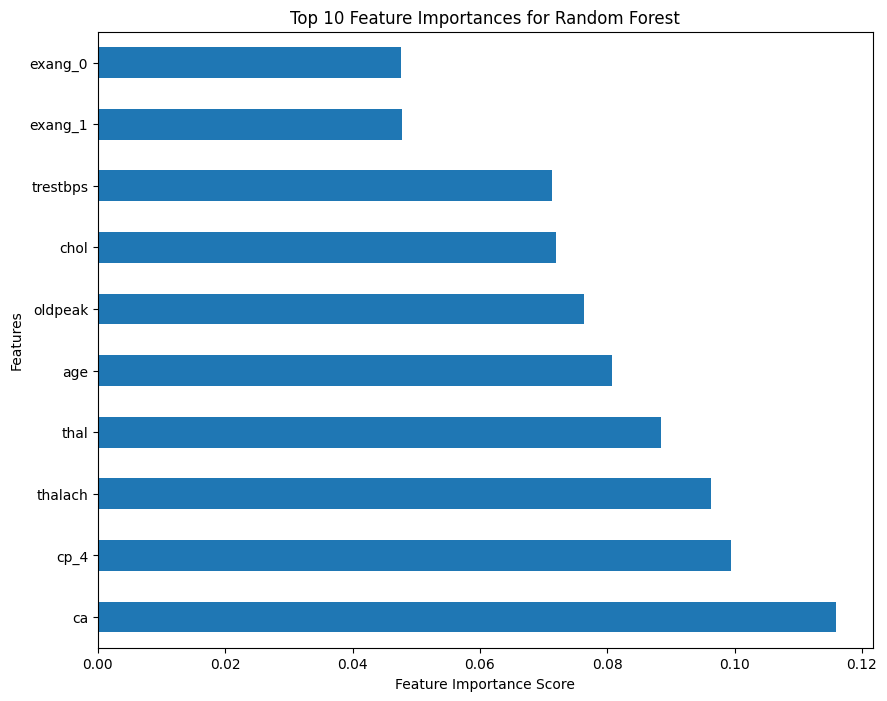

In [73]:
# Calculate feature importances
feat_importances = pd.Series(rf_classifier.feature_importances_, index=X.columns)

# Plot feature importances
plt.figure(figsize=(10, 8))
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances for Random Forest')
plt.show()

Hypertuning Random Forest Model

In [74]:
# Hyperparameters for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Grid search for Random Forest
rf_grid_search = GridSearchCV(rf_classifier, rf_param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(X_train_scaled, y_train)

# Best parameters for Random Forest
best_rf_params = rf_grid_search.best_params_


In [75]:
# Initialize a new Random Forest classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_rf_params, random_state=42)

# Train the Random Forest classifier with the best parameters on the entire training and validation data
best_rf_classifier.fit(np.concatenate([X_train_scaled, X_val_scaled]), np.concatenate([y_train, y_val]))

# Evaluate the final Random Forest model performance on the test set
final_predictions = best_rf_classifier.predict(X_test_scaled)
final_accuracy = accuracy_score(y_test, final_predictions)
final_precision = precision_score(y_test, final_predictions)
final_recall = recall_score(y_test, final_predictions)
final_f1_score = f1_score(y_test, final_predictions)

print("Random Forest Model Evaluation Metrics:")
print(f"Accuracy: {final_accuracy * 100:.2f}%")
print(f"Precision: {final_precision:.2f}")
print(f"Recall: {final_recall:.2f}")
print(f"F1 Score: {final_f1_score:.2f}")


Random Forest Model Evaluation Metrics:
Accuracy: 86.96%
Precision: 0.83
Recall: 0.90
F1 Score: 0.86


Plotting ROC curve and Confusion Matrix

False Negative Rate: 0.10


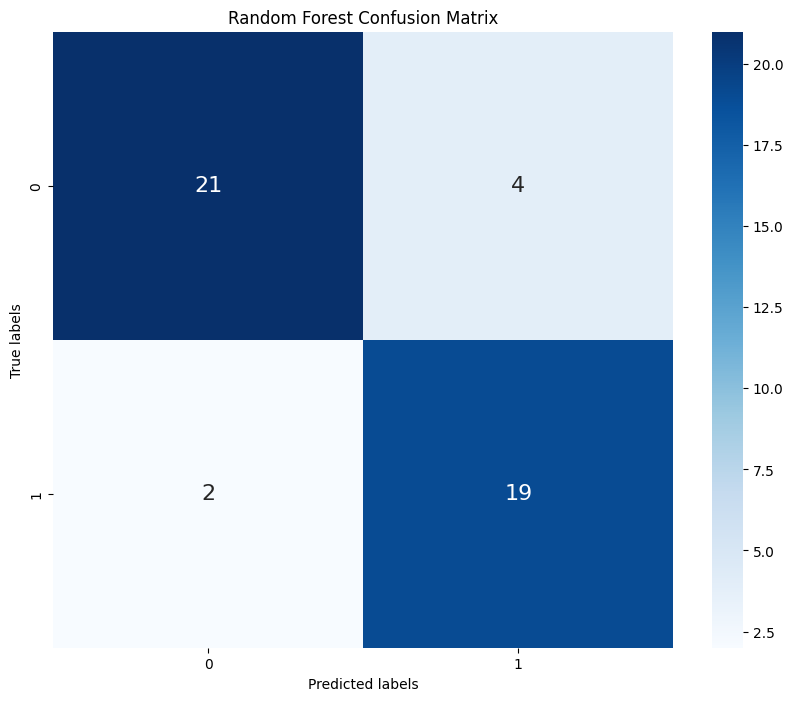

"plot_roc_curve(y_test, best_rf_classifier.predict_proba(X_test_scaled)[:, 1], model_name='Random Forest')"

In [114]:
# Plot confusion matrix and ROC curve for Random Forest
plot_confusion_matrix(y_test, final_predictions, title='Random Forest Confusion Matrix')
'''plot_roc_curve(y_test, best_rf_classifier.predict_proba(X_test_scaled)[:, 1], model_name='Random Forest')'''


**Decision Tree**

In [79]:
# Initialize the DT classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Perform cross-validation
cv_scores_dt = cross_val_score(dt_classifier, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores for Decision Tree
print("Cross-validation scores for Decision Tree:", cv_scores_dt)

# Calculate mean and standard deviation of cross-validation scores for Decision Tree
mean_cv_score_dt = cv_scores_dt.mean()
std_cv_score_dt = cv_scores_dt.std()

print("Mean Cross-validation score for Decision Tree:", mean_cv_score_dt)
print("Standard deviation of Cross-validation scores for Decision Tree:", std_cv_score_dt)

# Train the DT classifier
dt_classifier.fit(X_train_scaled, y_train)

models.append(dt_classifier)

Cross-validation scores for Decision Tree: [0.65116279 0.62790698 0.73809524 0.66666667 0.88095238]
Mean Cross-validation score for Decision Tree: 0.7129568106312292
Standard deviation of Cross-validation scores for Decision Tree: 0.09170518497327662


In [80]:
# Evaluate the baseline accuracy on the validation set
baseline_accuracy_percentage = accuracy_score(y_val, dt_classifier.predict(X_val_scaled)) * 100
print("Baseline Accuracy for Decision Tree: {:.2f}%".format(baseline_accuracy_percentage))


Baseline Accuracy for Decision Tree: 80.00%


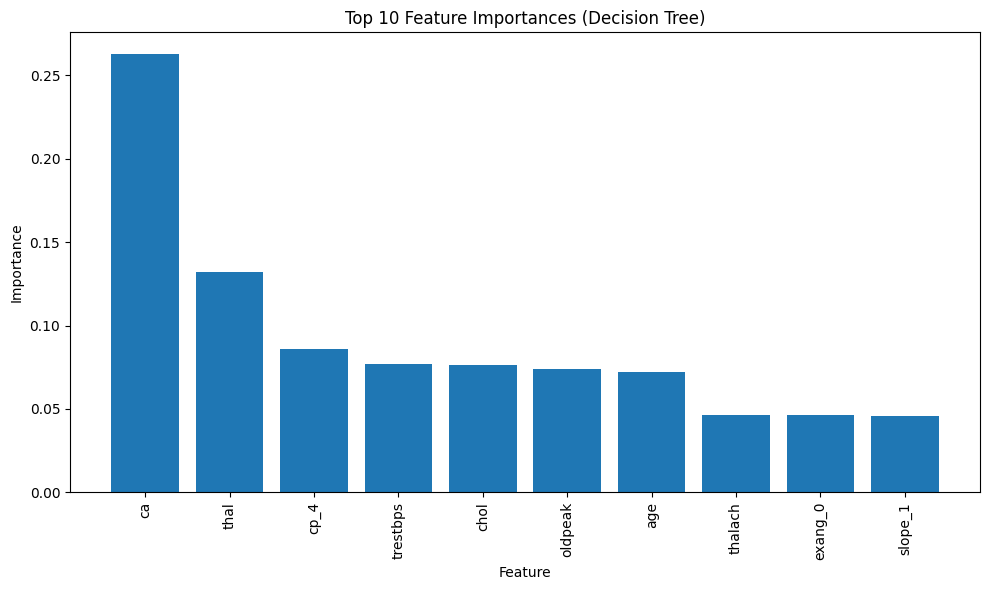

In [81]:
# Get feature importances from the trained Decision Tree model
feature_importances = dt_classifier.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = [X.columns[i] for i in sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Select top 10 features
top_features = sorted_features[:10]
top_importances = sorted_importances[:10]

# Plot feature importances for the top 10 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_importances)), top_importances, align='center')
plt.xticks(range(len(top_importances)), top_features, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances (Decision Tree)')
plt.tight_layout()
plt.show()


Hypertuning Decision Tree

In [82]:
# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Hyperparameters for Decision Tree
dt_param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Grid search for Decision Tree
dt_grid_search = GridSearchCV(dt_classifier, dt_param_grid, cv=5, scoring='accuracy')
dt_grid_search.fit(X_train_scaled, y_train)

# Best parameters for Decision Tree
print("Best Parameters for Decision Tree:", dt_grid_search.best_params_)

Best Parameters for Decision Tree: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5}


In [83]:
# Train the Decision Tree classifier with best hyperparameters
best_dt_classifier = DecisionTreeClassifier(**dt_grid_search.best_params_)
best_dt_classifier.fit(X_train_scaled, y_train)
# Predictions for the best Decision Tree classifier
best_dt_pred = best_dt_classifier.predict(X_test_scaled)

# Calculate evaluation metrics for the best Decision Tree classifier
best_dt_accuracy = accuracy_score(y_test, best_dt_pred) * 100
best_dt_precision = precision_score(y_test, best_dt_pred)
best_dt_recall = recall_score(y_test, best_dt_pred)
best_dt_f1 = f1_score(y_test, best_dt_pred)

print("Accuracy of the Best Decision Tree Classifier: {:.2f}%".format(best_dt_accuracy))
print("Precision of the Best Decision Tree Classifier:", best_dt_precision)
print("Recall of the Best Decision Tree Classifier:", best_dt_recall)
print("F1-score of the Best Decision Tree Classifier:", best_dt_f1)


Accuracy of the Best Decision Tree Classifier: 84.78%
Precision of the Best Decision Tree Classifier: 0.85
Recall of the Best Decision Tree Classifier: 0.8095238095238095
F1-score of the Best Decision Tree Classifier: 0.8292682926829269


Plot ROC Curve and Confusion Matrix

False Negative Rate: 0.19


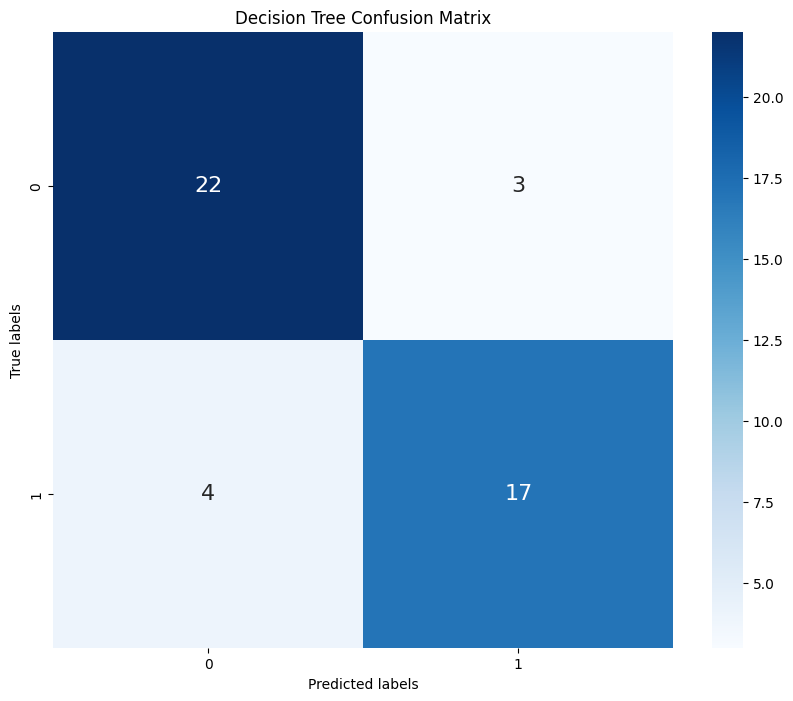

In [115]:
# Plot confusion matrix for the best Decision Tree classifier
plot_confusion_matrix(y_test, best_dt_pred, title='Decision Tree Confusion Matrix')

# Plot ROC curve for the best Decision Tree classifier
#plot_roc_curve(y_test, best_dt_classifier.predict_proba(X_test_scaled)[:, 1], model_name='Decision Tree')


**Logistic Regression**

In [85]:
# Initialize the LR classifier
lr_classifier = LogisticRegression(random_state=42)

# Perform cross-validation
cv_scores_lr = cross_val_score(lr_classifier, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores for Logistic Regression
print("Cross-validation scores for Logistic Regression:", cv_scores_lr)

# Calculate mean cross-validation score for Logistic Regression
mean_cv_score_lr = cv_scores_lr.mean()

print("Average Accuracy: {:.4f}".format(mean_cv_score_lr))

# Train the LR classifier
lr_classifier.fit(X_train_scaled, y_train)
models.append(lr_classifier)

Cross-validation scores for Logistic Regression: [0.86046512 0.8372093  0.78571429 0.80952381 0.9047619 ]
Average Accuracy: 0.8395


In [86]:
# Evaluate the baseline accuracy on the validation set for Logistic Regression
baseline_accuracy_percentage_lr = accuracy_score(y_val, lr_classifier.predict(X_val_scaled)) * 100
print("Baseline Accuracy for Logistic Regression: {:.2f}%".format(baseline_accuracy_percentage_lr))


Baseline Accuracy for Logistic Regression: 84.44%


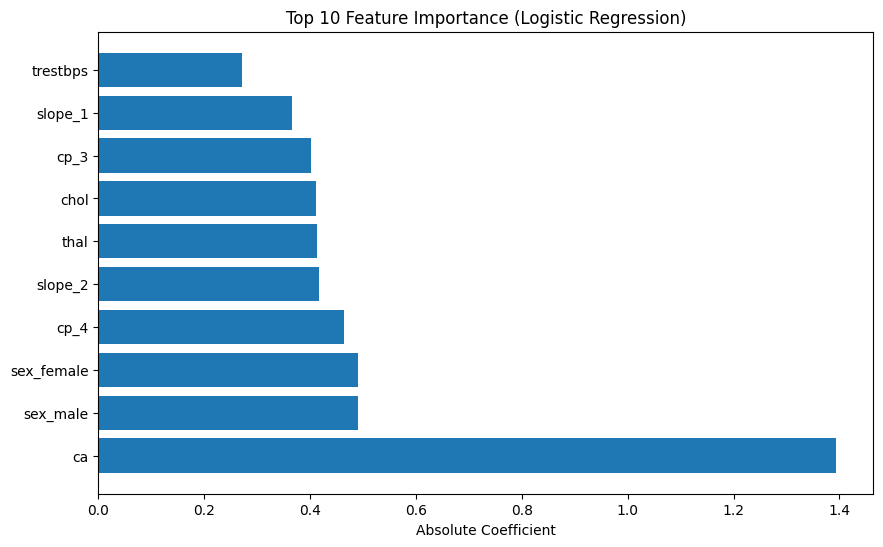

In [87]:
# Get coefficients and corresponding feature names
coefficients = lr_classifier.coef_[0]
feature_names = X.columns

# Create a DataFrame to store coefficients and feature names
feature_importance_lr = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort features by absolute coefficient values
feature_importance_lr['Absolute Coefficient'] = np.abs(feature_importance_lr['Coefficient'])
feature_importance_lr = feature_importance_lr.sort_values(by='Absolute Coefficient', ascending=False)

# Select top 10 features
top_feature_importance_lr = feature_importance_lr.head(10)

# Plot feature importance for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_feature_importance_lr['Feature'], top_feature_importance_lr['Absolute Coefficient'])
plt.xlabel('Absolute Coefficient')
plt.title('Top 10 Feature Importance (Logistic Regression)')
plt.show()


In [88]:
# Print feature importance
print("Feature Importance for Logistic Regression:")
print(feature_importance_lr)

Feature Importance for Logistic Regression:
       Feature  Coefficient  Absolute Coefficient
5           ca     1.394472              1.394472
22    sex_male     0.490500              0.490500
21  sex_female    -0.490500              0.490500
10        cp_4     0.464533              0.464533
19     slope_2     0.416768              0.416768
6         thal     0.413877              0.413877
2         chol     0.411795              0.411795
9         cp_3    -0.401504              0.401504
18     slope_1    -0.366312              0.366312
1     trestbps     0.272080              0.272080
7         cp_1    -0.231124              0.231124
16     exang_0    -0.196520              0.196520
17     exang_1     0.196520              0.196520
3      thalach    -0.172395              0.172395
4      oldpeak     0.155895              0.155895
14   restecg_1    -0.117864              0.117864
0          age     0.110314              0.110314
20     slope_3    -0.092018              0.092018
8     

Hyperparameter Tuning for Logistic Regression

In [89]:
# Define hyperparameters for Logistic Regression
lr_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [50, 100, 200]
}

# Instantiate Logistic Regression classifier
lr_classifier = LogisticRegression()

# Grid search for Logistic Regression
lr_grid_search = GridSearchCV(lr_classifier, lr_param_grid, cv=5, scoring='accuracy')
lr_grid_search.fit(X_train_scaled, y_train)

# Best parameters for Logistic Regression
print("Best Parameters for Logistic Regression:", lr_grid_search.best_params_)


Best Parameters for Logistic Regression: {'C': 1, 'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear'}


In [90]:
# Train the Logistic Regression classifier with best hyperparameters
best_lr_classifier = LogisticRegression(**lr_grid_search.best_params_)
best_lr_classifier.fit(X_train_scaled, y_train)

# Predictions for the best Logistic Regression classifier
best_lr_pred = best_lr_classifier.predict(X_test_scaled)

# Calculate accuracy, precision, recall, and F1-score for the best Logistic Regression classifier
best_lr_accuracy = accuracy_score(y_test, best_lr_pred)
best_lr_precision = precision_score(y_test, best_lr_pred)
best_lr_recall = recall_score(y_test, best_lr_pred)
best_lr_f1 = f1_score(y_test, best_lr_pred)

print(" Best Accuracy of the Best Logistic Regression Classifier:", best_lr_accuracy)
print("Precision of the Best Logistic Regression Classifier:", best_lr_precision)
print("Recall of the Best Logistic Regression Classifier:", best_lr_recall)
print("F1-score of the Best Logistic Regression Classifier:", best_lr_f1)

 Best Accuracy of the Best Logistic Regression Classifier: 0.8043478260869565
Precision of the Best Logistic Regression Classifier: 0.7307692307692307
Recall of the Best Logistic Regression Classifier: 0.9047619047619048
F1-score of the Best Logistic Regression Classifier: 0.8085106382978723


ROC Curve and Confusion Matrix

False Negative Rate: 0.10


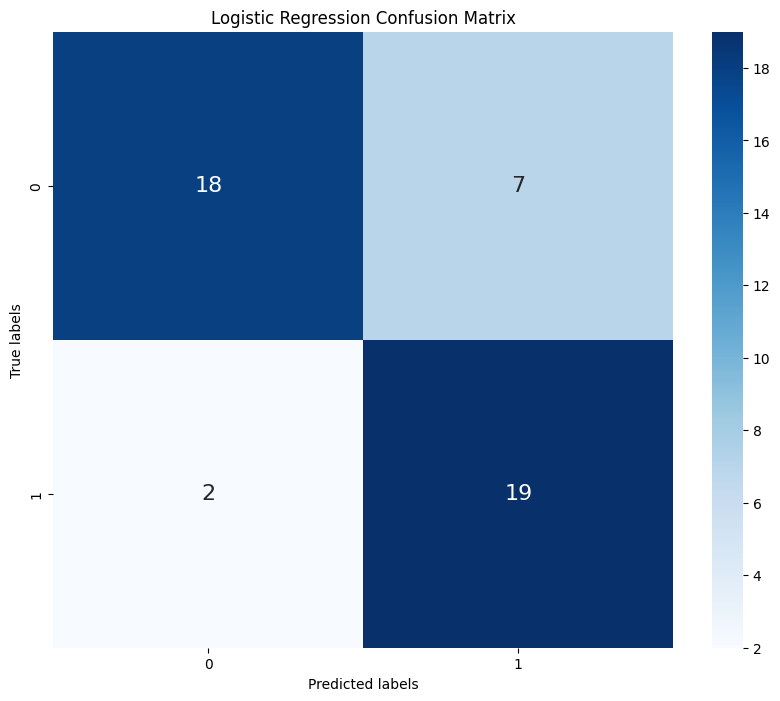

In [116]:
# Plot confusion matrix for Logistic Regression
plot_confusion_matrix(y_test, best_lr_pred, title='Logistic Regression Confusion Matrix')

# Plot ROC curve for Logistic Regression
#plot_roc_curve(y_test, best_lr_classifier.predict_proba(X_test_scaled)[:, 1], model_name='Logistic Regression')


In [117]:
'''import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot ROC curve for all models
plt.figure(figsize=(8, 6))

for model_idx, model in enumerate(models):
    model_name = model_names[model_idx]

    # Compute ROC curve and AUC
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Model Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()'''


"import matplotlib.pyplot as plt\nfrom sklearn.metrics import roc_curve, auc\n\n# Plot ROC curve for all models\nplt.figure(figsize=(8, 6))\n\nfor model_idx, model in enumerate(models):\n    model_name = model_names[model_idx]\n    \n    # Compute ROC curve and AUC\n    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]\n    fpr, tpr, _ = roc_curve(y_val, y_val_proba)\n    roc_auc = auc(fpr, tpr)\n    \n    # Plot ROC curve\n    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')\n\n# Plot ROC curve for random guessing\nplt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')\n\nplt.xlabel('False Positive Rate')\nplt.ylabel('True Positive Rate')\nplt.title('ROC Curve for Model Comparison')\nplt.legend(loc='lower right')\nplt.grid(True)\nplt.show()"

Validation and Testing

In [92]:
# Validation and Testing
for name, model in {"Random Forest": best_rf_classifier, "Decision Tree": best_dt_classifier, "Logistic Regression": best_lr_classifier}.items():
    print(f"Testing {name} on validation set...")
    y_val_pred = model.predict(X_val_scaled)

    # Model Evaluation on Validation Set
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='weighted')
    val_recall = recall_score(y_val, y_val_pred, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')

    print(f"\n{name}\nValidation Accuracy: {val_accuracy:.4f}\nValidation Precision: {val_precision:.4f}\nValidation Recall: {val_recall:.4f}\nValidation F1 Score: {val_f1:.4f}\n")

    # Testing
    print(f"Testing {name} on test set...")
    y_test_pred = model.predict(X_test_scaled)

    # Model Evaluation on Test Set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    print(f"\n{name}\nTest Accuracy: {test_accuracy:.4f}\nTest Precision: {test_precision:.4f}\nTest Recall: {test_recall:.4f}\nTest F1 Score: {test_f1:.4f}\n")


Testing Random Forest on validation set...

Random Forest
Validation Accuracy: 0.8667
Validation Precision: 0.8693
Validation Recall: 0.8667
Validation F1 Score: 0.8663

Testing Random Forest on test set...

Random Forest
Test Accuracy: 0.8696
Test Precision: 0.8733
Test Recall: 0.8696
Test F1 Score: 0.8698

Testing Decision Tree on validation set...

Decision Tree
Validation Accuracy: 0.7778
Validation Precision: 0.7796
Validation Recall: 0.7778
Validation F1 Score: 0.7771

Testing Decision Tree on test set...

Decision Tree
Test Accuracy: 0.8478
Test Precision: 0.8479
Test Recall: 0.8478
Test F1 Score: 0.8475

Testing Logistic Regression on validation set...

Logistic Regression
Validation Accuracy: 0.8222
Validation Precision: 0.8222
Validation Recall: 0.8222
Validation F1 Score: 0.8222

Testing Logistic Regression on test set...

Logistic Regression
Test Accuracy: 0.8043
Test Precision: 0.8227
Test Recall: 0.8043
Test F1 Score: 0.8039



Testing Random Forest on validation set...
Testing Random Forest on test set...


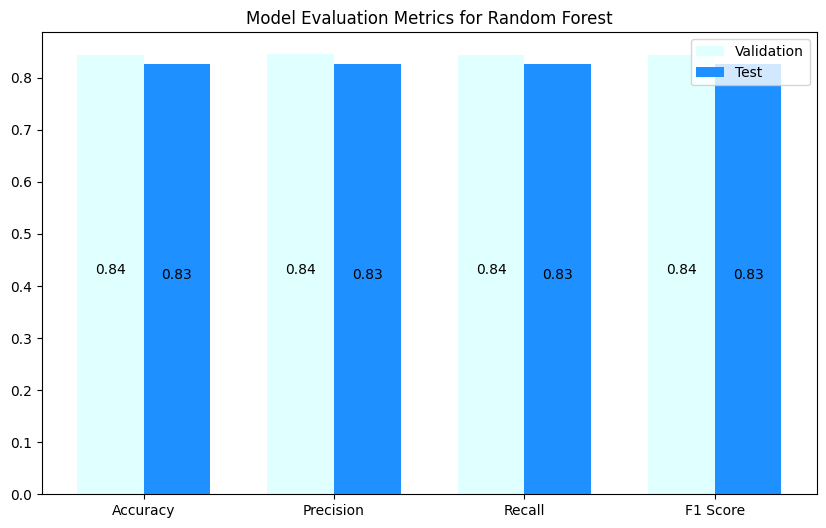

Testing Decision Tree on validation set...
Testing Decision Tree on test set...


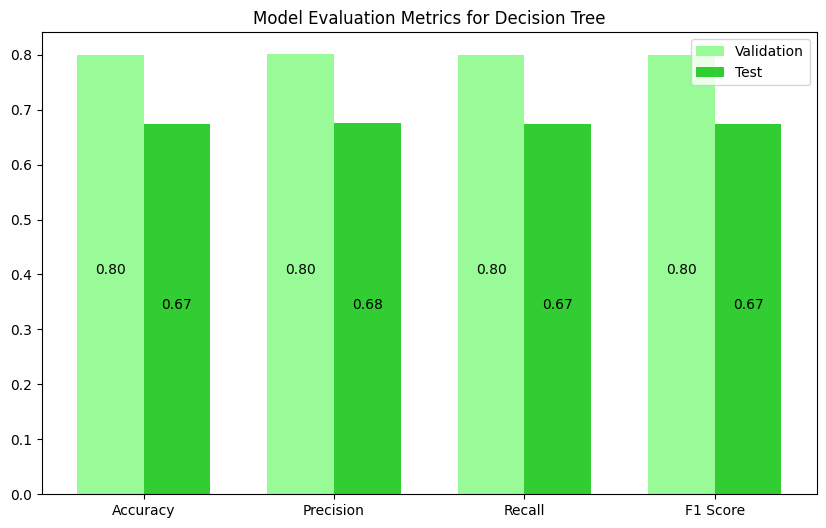

Testing Logistic Regression on validation set...
Testing Logistic Regression on test set...


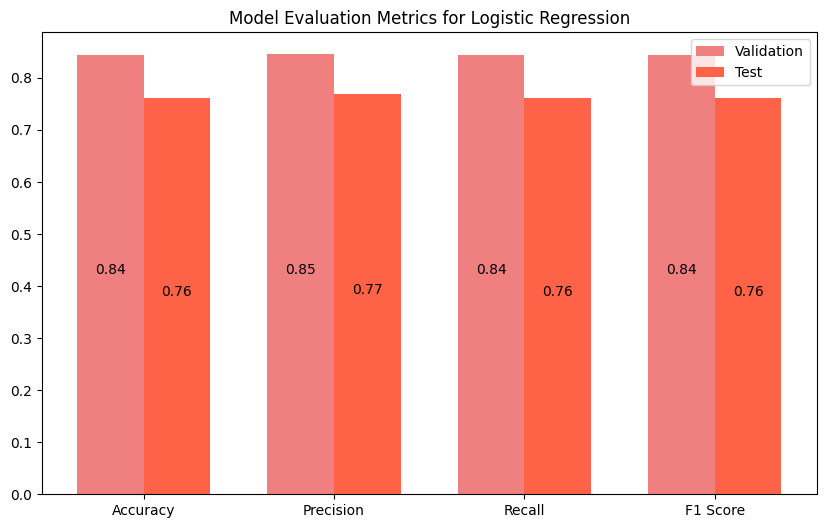

In [107]:
# Validation and Testing
model_names = ['Random Forest', 'Decision Tree', 'Logistic Regression']
colors = ['lightcyan', 'palegreen', 'lightcoral']  # Colors for validation set
test_colors = ['dodgerblue', 'limegreen', 'tomato']  # Colors for test set

for model_idx, model in enumerate(models):
    model_name = model_names[model_idx]
    color = colors[model_idx]
    test_color = test_colors[model_idx]

    print(f"Testing {model_name} on validation set...")
    y_val_pred = model.predict(X_val_scaled)

    # Model Evaluation on Validation Set
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='weighted')
    val_recall = recall_score(y_val, y_val_pred, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')

    # Testing
    print(f"Testing {model_name} on test set...")
    y_test_pred = model.predict(X_test_scaled)

    # Model Evaluation on Test Set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Plotting
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    val_scores = [val_accuracy, val_precision, val_recall, val_f1]
    test_scores = [test_accuracy, test_precision, test_recall, test_f1]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, val_scores, width, label='Validation', color=color)
    rects2 = ax.bar(x + width/2, test_scores, width, label='Test', color=test_color)

    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    ax.bar_label(rects1, padding=3, fmt='%.2f', label_type='center', fontsize=10, color='black', rotation=0)
    ax.bar_label(rects2, padding=3, fmt='%.2f', label_type='center', fontsize=10, color='black', rotation=0)

    plt.title(f'Model Evaluation Metrics for {model_name}')
    plt.show()


In [111]:
from prettytable import PrettyTable

# Initialize PrettyTable
table = PrettyTable()

# Define column names
table.field_names = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

# Validation and Testing
model_names = ['Random Forest', 'Decision Tree', 'Logistic Regression']

for model_idx, model in enumerate(models):
    model_name = model_names[model_idx]

    # Model Evaluation on Validation Set
    val_accuracy = accuracy_score(y_val, model.predict(X_val_scaled))
    val_precision = precision_score(y_val, model.predict(X_val_scaled), average='weighted')
    val_recall = recall_score(y_val, model.predict(X_val_scaled), average='weighted')
    val_f1 = f1_score(y_val, model.predict(X_val_scaled), average='weighted')

    # Model Evaluation on Test Set
    test_accuracy = accuracy_score(y_test, model.predict(X_test_scaled))
    test_precision = precision_score(y_test, model.predict(X_test_scaled), average='weighted')
    test_recall = recall_score(y_test, model.predict(X_test_scaled), average='weighted')
    test_f1 = f1_score(y_test, model.predict(X_test_scaled), average='weighted')

    # Add model name and metrics to table
    table.add_row([model_name,
                   f'Val: {val_accuracy:.2f}\nTest: {test_accuracy:.2f}',
                   f'Val: {val_precision:.2f}\nTest: {test_precision:.2f}',
                   f'Val: {val_recall:.2f}\nTest: {test_recall:.2f}',
                   f'Val: {val_f1:.2f}\nTest: {test_f1:.2f}'])

    # Add an empty row after each model
    table.add_row(['', '', '', '', ''])

# Remove the last empty row
table.del_row(-1)

# Print table
print(table)


+---------------------+------------+------------+------------+------------+
|        Model        |  Accuracy  | Precision  |   Recall   |  F1 Score  |
+---------------------+------------+------------+------------+------------+
|    Random Forest    | Val: 0.84  | Val: 0.84  | Val: 0.84  | Val: 0.84  |
|                     | Test: 0.83 | Test: 0.83 | Test: 0.83 | Test: 0.83 |
|                     |            |            |            |            |
|    Decision Tree    | Val: 0.80  | Val: 0.80  | Val: 0.80  | Val: 0.80  |
|                     | Test: 0.67 | Test: 0.68 | Test: 0.67 | Test: 0.67 |
|                     |            |            |            |            |
| Logistic Regression | Val: 0.84  | Val: 0.85  | Val: 0.84  | Val: 0.84  |
|                     | Test: 0.76 | Test: 0.77 | Test: 0.76 | Test: 0.76 |
+---------------------+------------+------------+------------+------------+
